# Import

In [1]:
import gc
gc.collect()

5

In [2]:
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fp = fm.FontProperties(fname='/home/studio-lab-user/Dacon/tools/NanumFont/NanumGothic.ttf', size=10)
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device :',device)

device : cpu


<br></br>

# Setting

<br>

## Hyperparameter Setting

In [4]:
CFG = {
    'EPOCHS':128,#1024,
    'PATIENCE':30,
    'LEARNING_RATE':0.05,
    'BATCH_SIZE':16,
    'SEED':42,
}

<br>

## Fixed RandomSeed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

<br></br>

# Data Pre-processing

In [6]:
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

class Preprocess:
    def __init__(self, input_paths, label_paths, test_input_paths, test_label_paths):
        
        self.input, self.label, self.test_input, self.test_label = None, None, None, None
        
        self.X_train, self.X_valid = None, None
        self.y_train, self.y_valid = None, None
        self.X, self.y = None, None

        input_fn = []
        label_fn = []
        for input_path, label_path in zip(input_paths, label_paths):
            case_num = input_path.replace('./data/train_input/CASE_','').replace('.csv','')
            
            input_df = pd.read_csv(input_path)
            label_df = pd.read_csv(label_path)

            input_df = input_df.fillna(0)

            input_df['case_num'] = case_num
            label_df['case_num'] = case_num
            
            input_fn.append(input_df)
            label_fn.append(label_df)
        
        test_input_fn = []
        test_label_fn = []
        for test_input_path, test_label_path in zip(test_input_paths, test_label_paths):
            case_num = test_input_path.replace('./data/test_input/TEST_','').replace('.csv','')
            
            test_input_df = pd.read_csv(test_input_path)
            test_label_df = pd.read_csv(test_label_path)
            
            test_input_df['case_num'] = case_num
            test_label_df['case_num'] = case_num
            
            test_input_fn.append(test_input_df)
            test_label_fn.append(test_label_df)
            
        self.input = pd.concat(input_fn,axis=0).sort_values(['case_num','DAT','obs_time'])
        self.label = pd.concat(label_fn,axis=0)
        self.test_input  = pd.concat(test_input_fn ,axis=0)
        self.test_label  = pd.concat(test_label_fn ,axis=0)
        
        self.input     .obs_time = list(np.arange(0,24))*int(self.input     .shape[0]/24)
        self.test_input.obs_time = list(np.arange(0,24))*int(self.test_input.shape[0]/24)
        
    def _data_return(self):
        return self.input,self.label,self.test_input,self.test_label
            
    def _target_log(self):
        self.label['predicted_weight_g'] = np.log(self.label['predicted_weight_g'])
    
    def _preprocess(self):
        # 1. time 추가 : 1~672 (24시간 x 28일)
        self.input     ['time'] = [i+1 for i in range(28*24)]*self.input     .case_num.nunique()
        self.test_input['time'] = [i+1 for i in range(28*24)]*self.test_input.case_num.nunique()

        features = [
            'DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', 
            '시간당분무량', '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', 
            '시간당청색광량', '일간누적청색광량', '시간당총광량', '일간누적총광량', 'case_num', 'time'
        ]
        # del_features = [
        #     '시간당분무량','시간당백색광량','시간당적색광량','시간당청색광량','시간당총광량',
        #     # '일간누적분무량','일간누적백색광량','일간누적적색광량','일간누적청색광량','일간누적총광량'
        # ]
        # self.input     .drop(columns=del_features,inplace=True)
        # self.test_input.drop(columns=del_features,inplace=True)
        
        # 2. 각 컬럼들의 파생변수
        input_df       = []
        test_input_df  = []
        for case_num in self.input.case_num.unique():
            i_df = self.input     [self.input     .case_num==case_num]
            t_df = self.test_input[self.test_input.case_num==case_num]
            
            for col in list(set(self.input.columns)-set(['case_num','DAT','obs_time','time'])):
                for i in range(4):
                    # (1) 이전시간 값
                    i_df[f'{col}_bf{i+1}'] = i_df[col].shift(i+1).fillna(0)
                    t_df[f'{col}_bf{i+1}'] = t_df[col].shift(i+1).fillna(0)
                
                    # (2) 전시간대 대비 상승했는지 여부
                    i_df[f'{col}_higher_than_{i+1}d'] = np.where(i_df[col]>i_df[col].shift(i+1),1,0)
                    t_df[f'{col}_higher_than_{i+1}d'] = np.where(t_df[col]>t_df[col].shift(i+1),1,0)

                
                    # # (3) 전시간대 대비 상승률 -> 넣으면 NaN 발생
                    # offset = 1e-3
                    # if i_df[col].min()<=0:
                    #     i_df[col] = i_df[col] + offset
                    #     t_df[col] = t_df[col] + offset
                    # i_df[f'{col}_{i+1}d_rise_rate'] = (i_df[col] - i_df[col].shift(i+1)) / i_df[col]
                    # t_df[f'{col}_{i+1}d_rise_rate'] = (t_df[col] - t_df[col].shift(i+1)) / t_df[col]
                    # i_df[f'{col}_{i+1}d_rise_rate'] = i_df[f'{col}_{i+1}d_rise_rate'].fillna(0)
                    # t_df[f'{col}_{i+1}d_rise_rate'] = t_df[f'{col}_{i+1}d_rise_rate'].fillna(0)
                
                # (4) cumulative sum
                i_df[f'{col}_cumsum'] = i_df[col].cumsum()
                t_df[f'{col}_cumsum'] = t_df[col].cumsum()

            input_df     .append(i_df)
            test_input_df.append(t_df)
        
        # concat
        self.input       = pd.concat(input_df     ,axis=0)
        self.test_input  = pd.concat(test_input_df,axis=0)
        
        # 파생변수 생성 후, 모든 값이 동일하면 삭제
        unique_info = self.input.apply(lambda x: x.nunique())
        unique_cols = unique_info[unique_info==1].index.tolist()
        
        # final dataset
        self.input      = self.input     .drop(unique_cols,axis=1)
        self.test_input = self.test_input.drop(unique_cols,axis=1)
        
    # https://dacon.io/competitions/official/236033/talkboard/407304?page=1&dtype=recent
    def _scale_dataset(self,outlier):
        
        minmax_info = {
            'none':[0,0],
            # 'time':[0,28*24],
            # '내부온도관측치':[4,40],
            # '내부습도관측치':[0,100],
            # 'co2관측치':[0,1200],
            # 'ec관측치':[0,8],
            # '시간당분무량':[0,3000],
            # '일간누적분무량':[0,72000],
            # '시간당백색광량':[0,120000],
            # '일간누적백색광량':[0,2880000],
            # '시간당적색광량':[0,120000],
            # '일간누적적색광량':[0,2880000],
            # '시간당청색광량':[0,120000],
            # '일간누적청색광량':[0,2880000],
            # '시간당총광량':[0,120000],
            # '일간누적총광량':[0,2880000],
        }
            
        scale_feature = [feature for feature,(min_info,max_info) in minmax_info.items() if feature in self.input.columns]
        
        # for train dataset
        for col in scale_feature:
            if col in self.input.columns:
                min_info,max_info = minmax_info[col]
                self.input[col] = (self.input[col]-min_info) / (max_info-min_info)

                if outlier=='keep':
                    # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                    # -> 삭제하게되면 24시간의 term이 깨짐
                    self.input[col][self.input[col]<0] = 0
                    self.input[col][self.input[col]>1] = 1
                elif outlier=='drop':
                    self.input[col][(self.input[col]<0) | (self.input[col]>1)] = np.nan
            
        # for test dataset
        for col in scale_feature:
            if col in self.test_input.columns:
                min_info,max_info = minmax_info[col]
                self.test_input[col] = (self.test_input[col]-min_info) / (max_info-min_info)

                if outlier=='keep':
                    # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                    # -> 삭제하게되면 24시간의 term이 깨짐
                    self.test_input[col][self.test_input[col]<0] = 0
                    self.test_input[col][self.test_input[col]>1] = 1
                elif outlier=='drop':
                    self.test_input[col][(self.test_input[col]<0) | (self.test_input[col]>1)] = np.nan
        
        another_features = list(set(self.input.select_dtypes(exclude=[object]).columns)-set(scale_feature))
        for col in another_features:
            min_info,max_info = self.input[col].min(),self.input[col].max()
            self.input[col]      = (self.input[col]     -min_info) / (max_info-min_info)
            self.test_input[col] = (self.test_input[col]-min_info) / (max_info-min_info)
        
    def _interaction_term(self):
        # num_features = self.input.select_dtypes(exclude=[object]).columns
        # num_features = list(set(num_features)-set(['DAT','obs_time']))
        num_features = [
            'DAT','time','obs_time',
            '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', 
            '시간당분무량', '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', 
            '시간당청색광량', '일간누적청색광량', '시간당총광량', '일간누적총광량',
        ]
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    self.input     [f'{num_features[i]}*{num_features[j]}'] = self.input     [num_features[i]]*self.input     [num_features[j]]
                    self.test_input[f'{num_features[i]}*{num_features[j]}'] = self.test_input[num_features[i]]*self.test_input[num_features[j]]

In [7]:
def abline(slope, intercept, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color)

In [8]:
# from scipy.stats import pearsonr

# val_rate = 0.05

# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# dataset._preprocess()
# dataset._scale_dataset()
# input_df, label_df = dataset._data_return()

# for case_num in tqdm(sorted(input_df.case_num.unique())):

#     input = input_df[input_df.case_num==case_num].drop('case_num',axis=1)
#     label = label_df[label_df.case_num==case_num].drop('case_num',axis=1)

#     fig = plt.figure(figsize=(20,15))
#     nrow = 3
#     ncol = 5

#     iter = 0
#     total = len(input.columns)-3
#     for col in input.columns:
#         if col not in ['time','DAT','obs_time']:
#             iter+=1

#             y1 = input[col]
#             #y1 = (y1-y1.min())/(y1.max()-y1.min())

#             y2 = label['predicted_weight_g']
#             y2 = (y2-y2.min())/(y2.max()-y2.min())

#             y3 = input.groupby('DAT')[col].mean().values

#             corr, pvalue = pearsonr(y2,y3)

#             fig.add_subplot(ncol,nrow,iter)
#             sns.scatterplot(x=input.time  ,y=y1)
#             sns.scatterplot(x=label.DAT*24,y=y2,color='red')
#             sns.lineplot   (x=label.DAT*24,y=y3,color='blue',linestyle='--',alpha=0.7)
#             plt.ylabel('')

#             plt.title(f'{col}(corr={corr:.3f}(pvalue={pvalue:.3f}))',fontproperties=fp)


#     plt.tight_layout()
#     plt.savefig(f'./fig/{case_num}.png',dpi=100)
#     plt.close()

<br></br>

# Model Define

<br>

## LSTM Model

In [9]:
# https://coding-yoon.tistory.com/131

<br>

## Train, Validation Define

In [10]:
# # https://tutorials.pytorch.kr/recipes/recipes/tensorboard_with_pytorch.html
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter('runs/NLinear')

In [11]:
from lib.EarlyStopping import EarlyStopping

inverse_transform_function = np.exp

In [12]:
def rmse_loss_fn(output, target):
    return torch.sqrt(torch.mean((output-target)**2))

In [13]:
import time

def train(
    model, optimizer, train_loader, valid_loader, scheduler, device, 
    early_stopping, epochs, metric_period=1, best_model_only=True, verbose=True,
):
    
    es = EarlyStopping(patience = CFG['ES_PATIENCE'], verbose = CFG['ES_VERBOSE'], path='./model/checkpoint.pt')
    
    model.to(device)
    # criterion = nn.L1Loss().to(device)
    criterion = nn.MSELoss().to(device)

    best_loss = 9999
    best_model = None
    start_time = time.time()
    epoch_s = time.time()
    for epoch in range(1, epochs+1):
        
        model.train()
        train_loss = []
        for X, Y in iter(train_loader):

            X = X.float().to(device)
            Y = Y.float().to(device)

            optimizer.zero_grad()
            output = model(X).float()
            # print(output.shape,Y.shape) # torch.Size([4, 28, 1]) torch.Size([4, 24])
            # print(output[:5],Y[:5])
            
            # # log -> exp
            # output = torch.exp(output)
            # Y      = torch.exp(Y)
            
            # print(output[:5],Y[:5],output.shape,Y.shape)
            loss = criterion(output, Y)
            loss = torch.sqrt(loss) # MSE -> RMSE
            
            loss.backward() # Getting gradients
            optimizer.step() # Updating parameters

            train_loss.append(loss.item())

        valid_loss = validation(model, valid_loader, criterion, device)

        epoch_e = time.time()
        
        # writer.add_scalar("Loss/train", loss, epoch)
        # writer.add_scalar("Loss/validation", valid_loss, epoch)
        # if epoch==epochs:
        #     writer.close()
            
        if scheduler is not None:
            scheduler.step(valid_loss)

        if verbose:
            if epoch % metric_period == 0:
                epoch_str = '0'*(len(str(epochs))-len(str(epoch))) + str(epoch)
                progress = '[{}/{}] tr_loss : {:.5f}, val_loss : {:.5f}, elapsed : {:.2f}s, total : {:.2f}s, remaining : {:.2f}s'\
                    .format(
                        epoch_str,
                        epochs,np.mean(train_loss),
                        valid_loss,
                        epoch_e-epoch_s,
                        epoch_e-start_time,
                        (epoch_e-epoch_s)*(epochs-epoch)
                    )
                epoch_s = time.time()

                if best_loss > valid_loss:
                    mark = '*'
                else:
                    mark = ' '
            
                print(mark+progress)
            
        if best_model_only:
            if best_loss > valid_loss:
                best_loss = valid_loss
                best_model = model
                
                path = f'./model/best_model.pt'
                torch.save(best_model.state_dict(), path)

        # early stopping 여부를 체크. 현재 과적합 상황 추적
        if early_stopping:
            es(valid_loss, model)

            if es.early_stop:
                break

    return best_model

In [14]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = []
    with torch.no_grad():
        for X, Y in iter(valid_loader):
            X = X.float().to(device)
            Y = Y.float().to(device)

            output = model(X).float()
            
            # # log -> exp
            # output = torch.exp(output)
            # Y      = torch.exp(Y)
            
            loss = criterion(output, Y)
            loss = torch.sqrt(loss) # MSE -> RMSE

            valid_loss.append(loss.item())

    return np.mean(valid_loss)

<br></br>

# Modeling

In [15]:
# np.array(input_list).shape
# [x.size() for x in input_list]

# [x.size() for x in label_list]

In [16]:
# [x.size() for x in input_list]
# [x.size() for x in label_list]
# torch.Tensor(y_seq.values)

In [17]:
class CustomDataset(Dataset):
    def __init__(self,input,label,infer_mode,seq_length):
        self.infer_mode = infer_mode
        
        input = input.sort_values(['case_num','DAT','obs_time'])
        label = label.sort_values(['case_num','DAT'])

        input_window_size = 24*28
        label_window_size = 28

        self.input_list = []
        self.label_list = []
        for i in range(int(input.shape[0]/input_window_size)):
            # input_df = self.input.iloc[i]
            input_df = input.iloc[i*input_window_size : (i+1)*input_window_size,:]
            label_df = label.iloc[i*label_window_size : (i+1)*label_window_size  ]

            # seq_length = 12
            for j in range(label_df.shape[0]-seq_length+1):
                x_seq = input_df.iloc[j*24:(j+seq_length)*24,:].drop(columns=['case_num']) # 'DAT','obs_time','time'
                y_seq = label_df.iloc[j   : j+seq_length]      ['predicted_weight_g']

                self.input_list.append(torch.Tensor(x_seq.values))
                self.label_list.append(torch.Tensor(y_seq.values))

    def __getitem__(self, index):
        data  = self.input_list[index]
        label = self.label_list[index]
        if self.infer_mode == False:
            return data, label
        else:
            return data

    def __len__(self):
        return len(self.input_list)

In [18]:
# from sklearn.model_selection import KFold

# n_split = 2

# # Preprocess Class
# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# # (1) preprocessing + scaling + interaction term
# dataset._preprocess()
# # dataset._feature_exp()
# dataset._scale_dataset()
# # dataset._interaction_term()

# # (2) Data Return for check
# input_df, label_df, test_df = dataset._data_return()

# # (3) Select Columns
# input_df = input_df.drop(columns=['obs_time'])
# label_df = label_df['predicted_weight_g']

# # (4) train/validaion split을 위한 index 생성
# input_df['idx'] = np.repeat(np.arange(0,28*28),24)

# # (5) delete features
# input_df = input_df.drop(del_features,axis=1)

# test_preds = []
# kf = KFold(n_splits=n_split, shuffle=True, random_state=42)
# for tr_idx,va_idx in tqdm(kf.split(label_df),total=n_split):
    
#     X_train = input_df[input_df.idx.isin(tr_idx)].drop(['idx','case_num'],axis=1)
#     X_valid = input_df[input_df.idx.isin(va_idx)].drop(['idx','case_num'],axis=1)
#     y_train = label_df.iloc[tr_idx]
#     y_valid = label_df.iloc[va_idx]
    
#     # #temp
#     # X_train = X_train.groupby(['case_num','DAT']).mean().reset_index().drop(['idx','case_num'],axis=1)
#     # X_valid = X_valid.groupby(['case_num','DAT']).mean().reset_index().drop(['idx','case_num'],axis=1)
    
#     # X_train['DAT'] = (X_train['DAT']-0)/(28-0)
#     # X_valid['DAT'] = (X_valid['DAT']-0)/(28-0)
#     # X_train = X_train.drop('DAT',axis=1)
#     # X_valid = X_valid.drop('DAT',axis=1)
    
#     train_dataset = CustomDataset(input=X_train, label=y_train, infer_mode=False)
#     # train_datatset = TensorDataset(torch.from_numpy(X_train.values),torch.from_numpy(y_train.values))
#     train_loader  = DataLoader(train_dataset, batch_size = 1024, shuffle=False, num_workers=6) # CFG['BATCH_SIZE']
#     # train_loader = DataLoader(train_dataset, num_workers=8)

#     valid_dataset = CustomDataset(input=X_valid, label=y_valid, infer_mode=False)
#     # valid_datatset = TensorDataset(torch.from_numpy(X_valid.values),torch.from_numpy(y_valid.values))
#     valid_loader  = DataLoader(valid_dataset, batch_size = 1024, shuffle=False, num_workers=6) # CFG['BATCH_SIZE']
#     # valid_loader = DataLoader(valid_dataset, num_workers=8)
    
#     # input_size = [np.array(x[0]).shape for x in train_loader][0][2]
#     model = BaseModel(
#         input_size = X_train.shape[1],
#         hidden_sizes=[64,32],
#         dropout_rates=[0.2,0.2],
#         num_classes=1,
#         num_layers=1,
#         bidirectional=False,
#     )
#     # model = GRUModel(input_dim=X_train.shape[1], hidden_dim=64, layer_dim=1, output_dim=1)
    
#     model.eval()
#     optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])#, weight_decay=1e-5)
#     # optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-4, momentum=0.9)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=0.5, patience=2, threshold_mode='abs',min_lr=1e-8, verbose=False)

#     best_model = train(
#         model,
#         optimizer=optimizer,
#         train_loader=train_loader,
#         valid_loader=valid_loader,
#         scheduler=scheduler,
#         device=device,
#         early_stopping=False,
#         metric_period=1,
#         epochs=2,
#     )
    
#     test_df = test_df[X_train.columns]
#     test_dataset = CustomTestDataset(input=test_df)
#     test_loader  = DataLoader(test_dataset, batch_size = 1024, shuffle=False, num_workers=0)

#     model.to(device)
#     model.eval()
#     test_pred = []
#     with torch.no_grad():
#         for X in iter(test_loader):
#             X = X.float().to(device)

#             model_pred = model(X)
#             # model_pred = torch.exp(model_pred)
#             model_pred = model_pred.cpu().numpy().reshape(-1).tolist()

#             test_pred += model_pred
            
#     test_preds.append(test_pred)

In [19]:
# from sklearn.model_selection import train_test_split

# # Preprocess Class
# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# # (1) preprocessing + scaling + interaction term
# dataset._preprocess()
# # dataset._target_log()
# dataset._scale_dataset()
# # dataset._interaction_term()

# # (2) Data Return for check
# input_df, label_df, test_df = dataset._data_return()

# # (4) Select Columns
# input_df = input_df.drop(columns=['obs_time'])
# # label_df = label_df['predicted_weight_g']

# plot_df = input_df.copy()
# features = input_df.drop(['DAT','case_num','time'],axis=1).columns

# for col in ['predicted_weight_g']:
#     label_df[col] = (label_df[col]-label_df[col].min()) / (label_df[col].max()-label_df[col].min())
# for col in features:
#     plot_df[col] = (plot_df[col] - plot_df[col].min()) / (plot_df[col].max()-plot_df[col].min())

# for col in features:
#     palette = sns.color_palette("pastel",plot_df.case_num.nunique())
#     plt.figure(figsize=(15,7))

#     i=0
#     for case_num in plot_df.case_num.unique():
#         d1 = plot_df[plot_df.case_num==case_num]
#         d2 = label_df[label_df.case_num==case_num]
#         sns.lineplot(x=d1['time']*d2['DAT'].max()*24,y=d1[col],alpha=0.5,color=palette[i])
#         sns.lineplot(x=d2['DAT']*24,y=d2['predicted_weight_g'],color=palette[i])
#         i+=1

#     plt.xlabel('')
#     plt.ylabel('')
#     plt.title(col,fontproperties=fp)
#     plt.show()

In [20]:
# agg_df = plot_df.groupby(['time']).mean().reset_index()

# for col in features:

#     x = plot_df['time']
#     y1 = plot_df[col]
#     y2 = (label_df-label_df.min()) / (label_df.max()-label_df.min())
#     y3 = agg_df[col]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(x=x,y=y1,alpha=0.5)
#     sns.scatterplot(x=y2.index*24,y=y2,color='red')
#     sns.lineplot(x=agg_df['time'],y=y3,color='black')
#     plt.title(col,fontproperties=fp)
#     plt.ylabel('')
#     plt.show()

In [21]:
all_input_list = sorted(glob.glob('./data/train_input/*.csv'))
all_label_list = sorted(glob.glob('./data/train_target/*.csv'))
all_test_input_list = sorted(glob.glob('./data/test_input/*.csv'))
all_test_label_list = sorted(glob.glob('./data/test_target/*.csv'))

In [22]:
from sklearn.model_selection import train_test_split

# Preprocess Class
dataset = Preprocess(
    input_paths = all_input_list,
    label_paths = all_label_list,
    test_input_paths = all_test_input_list,
    test_label_paths = all_test_label_list,
)

# (1) preprocessing + scaling + interaction term
dataset._preprocess()
# dataset._target_log()
dataset._scale_dataset(outlier='keep')
dataset._interaction_term()

# (2) Data Return for check
input_df, label_df, test_input_df, test_label_df = dataset._data_return()

# # (3) Delete Std zero features
# std_zero_features = []
# for case_num in input_df.case_num.unique():
#     tmp = input_df[input_df.case_num==case_num]
#     std_zero_feature = tmp.std().index[tmp.std()==0].tolist()
#     std_zero_features += std_zero_feature
    
# std_zero_features = pd.unique(std_zero_features)

# input_df = input_df.drop(std_zero_features,axis=1)

# # (4) Select Columns
# input_df = input_df.drop(columns=['obs_time'])
# label_df = label_df['predicted_weight_g']

In [23]:
input_df.head()

,DAT,obs_time,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량,case_num,time,ec관측치_bf1,ec관측치_higher_than_1d,ec관측치_bf2,ec관측치_higher_than_2d,ec관측치_bf3,ec관측치_higher_than_3d,ec관측치_bf4,ec관측치_higher_than_4d,ec관측치_cumsum,일간누적청색광량_bf1,일간누적청색광량_higher_than_1d,일간누적청색광량_bf2,일간누적청색광량_higher_than_2d,일간누적청색광량_bf3,일간누적청색광량_higher_than_3d,일간누적청색광량_bf4,일간누적청색광량_higher_than_4d,일간누적청색광량_cumsum,내부습도관측치_bf1,내부습도관측치_higher_than_1d,내부습도관측치_bf2,내부습도관측치_higher_than_2d,내부습도관측치_bf3,내부습도관측치_higher_than_3d,내부습도관측치_bf4,내부습도관측치_higher_than_4d,내부습도관측치_cumsum,일간누적적색광량_bf1,일간누적적색광량_higher_than_1d,일간누적적색광량_bf2,일간누적적색광량_higher_than_2d,일간누적적색광량_bf3,일간누적적색광량_higher_than_3d,일간누적적색광량_bf4,일간누적적색광량_higher_than_4d,일간누적적색광량_cumsum,시간당적색광량_bf1,시간당적색광량_higher_than_1d,시간당적색광량_bf2,시간당적색광량_higher_than_2d,시간당적색광량_bf3,시간당적색광량_higher_than_3d,시간당적색광량_bf4,시간당적색광량_higher_than_4d,시간당적색광량_cumsum,일간누적총광량_bf1,일간누적총광량_higher_than_1d,일간누적총광량_bf2,일간누적총광량_higher_than_2d,일간누적총광량_bf3,일간누적총광량_higher_than_3d,일간누적총광량_bf4,일간누적총광량_higher_than_4d,일간누적총광량_cumsum,시간당청색광량_bf1,시간당청색광량_higher_than_1d,시간당청색광량_bf2,시간당청색광량_higher_than_2d,시간당청색광량_bf3,시간당청색광량_higher_than_3d,시간당청색광량_bf4,시간당청색광량_higher_than_4d,시간당청색광량_cumsum,시간당총광량_bf1,시간당총광량_higher_than_1d,시간당총광량_bf2,시간당총광량_higher_than_2d,시간당총광량_bf3,시간당총광량_higher_than_3d,시간당총광량_bf4,시간당총광량_higher_than_4d,시간당총광량_cumsum,내부온도관측치_bf1,내부온도관측치_higher_than_1d,내부온도관측치_bf2,내부온도관측치_higher_than_2d,내부온도관측치_bf3,내부온도관측치_higher_than_3d,내부온도관측치_bf4,내부온도관측치_higher_than_4d,내부온도관측치_cumsum,일간누적백색광량_bf1,일간누적백색광량_higher_than_1d,일간누적백색광량_bf2,일간누적백색광량_higher_than_2d,일간누적백색광량_bf3,일간누적백색광량_higher_than_3d,일간누적백색광량_bf4,일간누적백색광량_higher_than_4d,일간누적백색광량_cumsum,일간누적분무량_bf1,일간누적분무량_higher_than_1d,일간누적분무량_bf2,일간누적분무량_higher_than_2d,일간누적분무량_bf3,일간누적분무량_higher_than_3d,일간누적분무량_bf4,일간누적분무량_higher_than_4d,일간누적분무량_cumsum,시간당백색광량_bf1,시간당백색광량_higher_than_1d,시간당백색광량_bf2,시간당백색광량_higher_than_2d,시간당백색광량_bf3,시간당백색광량_higher_than_3d,시간당백색광량_bf4,시간당백색광량_higher_than_4d,시간당백색광량_cumsum,시간당분무량_bf1,시간당분무량_higher_than_1d,시간당분무량_bf2,시간당분무량_higher_than_2d,시간당분무량_bf3,시간당분무량_higher_than_3d,시간당분무량_bf4,시간당분무량_higher_than_4d,시간당분무량_cumsum,co2관측치_bf1,co2관측치_higher_than_1d,co2관측치_bf2,co2관측치_higher_than_2d,co2관측치_bf3,co2관측치_higher_than_3d,co2관측치_bf4,co2관측치_higher_than_4d,co2관측치_cumsum,time*DAT,obs_time*DAT,obs_time*time,내부온도관측치*DAT,내부온도관측치*time,내부온도관측치*obs_time,내부습도관측치*DAT,내부습도관측치*time,내부습도관측치*obs_time,내부습도관측치*내부온도관측치,co2관측치*DAT,co2관측치*time,co2관측치*obs_time,co2관측치*내부온도관측치,co2관측치*내부습도관측치,ec관측치*DAT,ec관측치*time,ec관측치*obs_time,ec관측치*내부온도관측치,ec관측치*내부습도관측치,ec관측치*co2관측치,시간당분무량*DAT,시간당분무량*time,시간당분무량*obs_time,시간당분무량*내부온도관측치,시간당분무량*내부습도관측치,시간당분무량*co2관측치,시간당분무량*ec관측치,일간누적분무량*DAT,일간누적분무량*time,일간누적분무량*obs_time,일간누적분무량*내부온도관측치,일간누적분무량*내부습도관측치,일간누적분무량*co2관측치,일간누적분무량*ec관측치,일간누적분무량*시간당분무량,시간당백색광량*DAT,시간당백색광량*time,시간당백색광량*obs_time,시간당백색광량*내부온도관측치,시간당백색광량*내부습도관측치,시간당백색광량*co2관측치,시간당백색광량*ec관측치,시간당백색광량*시간당분무량,시간당백색광량*일간누적분무량,일간누적백색광량*DAT,일간누적백색광량*time,일간누적백색광량*obs_time,일간누적백색광량*내부온도관측치,일간누적백색광량*내부습도관측치,일간누적백색광량*co2관측치,일간누적백색광량*ec관측치,일간누적백색광량*시간당분무량,일간누적백색광량*일간누적분무량,일간누적백색광량*시간당백색광량,시간당적색광량*DAT,시간당적색광량*time,시간당적색광량*obs_time,시간당적색광량*내부온도관측치,시간당적색광량*내부습도관측치,시간당적색광량*co2관측치,시간당적색광량*ec관측치,시간당적색광량*시간당분무량,시간당적색광량*일간누적분무량,시간당적색광량*시간당백색광량,시간당적색광량*일간누적백색광량,일간누적적색광량*DAT,일간누적적색광량*time,일간누적적색광량*obs_time,일간누적적색광량*내부온도관측치,일간누적적색광량*내부습도관측치,일간누적적색광량*co2관측치,일간누적적색광량*ec관측치,일간누적적색광량*시간당분무량,일간누적적색광량*일간누적분무량,일간누적적색광량*시간당백색광량,일간누적적색광량*일간누적백색광량,일간누적적색광량*시간당적색광량,시간당청색광량*DAT,시간당청색광량*time,시간당청색광량*obs_time,시간당청색광량*내부온도관측치,시간당청색광량*내부습도관측치,시간당청색광량*co2관측치,시간당청색광량*ec관측치,시간당청색광량*시간당분무량,시간당청색광량*일간누적분무량,시간당청색광량*시간당백색광량,시간당청색광량*일간누적백색광량,시간당청색광량*시간당적색광량,시간당청색광량*일간누적적색광량,일간누적청색광량*DAT,일간누적청색광량*time,일간누적청색광량*obs_time,일간누적청색광량*내부온도관측치,일간누적청색광량*내부습도관측치,일간누적청색광량*co2관측치,일간누적청색광량*ec관측치,일간누적청색광량*시간당분무량,일간누적청색광량*일간누적분무량,일간누적청색광량*시간당백색광량,일간누적청색광량*일간누적백색광량,일간누적청색광량*시간당적색광량,일간누적청색광량*일간누적적색광량,일간누적청색광량*시간당청색광량,시간당총광량*DAT,시간당총광량*time,시간당총광량*obs_time,시간당총광량*내부온도관측치,시간당총광량*내부습도관측치,시간당총광량*co2관측치,시간당총광량*ec관측치,시간당총광량*시간당분무량,시간당총광량*일간누적분무량,시간당

In [24]:
# input_df.isnull().sum()
input_df.shape

(18816, 280)

In [25]:
print([col for col in input_df.columns if col.find('*')<0])
# print(input_df.columns)

['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량', '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량', '일간누적청색광량', '시간당총광량', '일간누적총광량', 'case_num', 'time', 'ec관측치_bf1', 'ec관측치_higher_than_1d', 'ec관측치_bf2', 'ec관측치_higher_than_2d', 'ec관측치_bf3', 'ec관측치_higher_than_3d', 'ec관측치_bf4', 'ec관측치_higher_than_4d', 'ec관측치_cumsum', '일간누적청색광량_bf1', '일간누적청색광량_higher_than_1d', '일간누적청색광량_bf2', '일간누적청색광량_higher_than_2d', '일간누적청색광량_bf3', '일간누적청색광량_higher_than_3d', '일간누적청색광량_bf4', '일간누적청색광량_higher_than_4d', '일간누적청색광량_cumsum', '내부습도관측치_bf1', '내부습도관측치_higher_than_1d', '내부습도관측치_bf2', '내부습도관측치_higher_than_2d', '내부습도관측치_bf3', '내부습도관측치_higher_than_3d', '내부습도관측치_bf4', '내부습도관측치_higher_than_4d', '내부습도관측치_cumsum', '일간누적적색광량_bf1', '일간누적적색광량_higher_than_1d', '일간누적적색광량_bf2', '일간누적적색광량_higher_than_2d', '일간누적적색광량_bf3', '일간누적적색광량_higher_than_3d', '일간누적적색광량_bf4', '일간누적적색광량_higher_than_4d', '일간누적적색광량_cumsum', '시간당적색광량_bf1', '시간당적색광량_higher_than_1d', '시간당적색광량_bf2', '시간당적색광량_higher_than_2d'

In [26]:
random.seed(42)

n = input_df.case_num.nunique()
val_rate = 0.3

valid_size = int(n*val_rate)
train_size = n-valid_size
print(f'train_size = {train_size}, valid_size : {valid_size}')

random_num = random.sample(range(n),valid_size)
print('validation CASE_NUMBER :',random_num)

train_size = 20, valid_size : 8
validation CASE_NUMBER : [20, 3, 0, 23, 8, 7, 22, 4]


In [27]:
va_case_num = input_df.case_num.unique()[random_num].tolist()
tr_case_num = list(set(input_df.case_num.unique())-set(va_case_num))

X_train = input_df[input_df.case_num.isin(tr_case_num)]#.drop(columns=['case_num','time','DAT','obs_time'])
X_valid = input_df[input_df.case_num.isin(va_case_num)]#.drop(columns=['case_num','time','DAT','obs_time'])

y_train = label_df[label_df.case_num.isin(tr_case_num)]#['predicted_weight_g']
y_valid = label_df[label_df.case_num.isin(va_case_num)]#['predicted_weight_g']

train


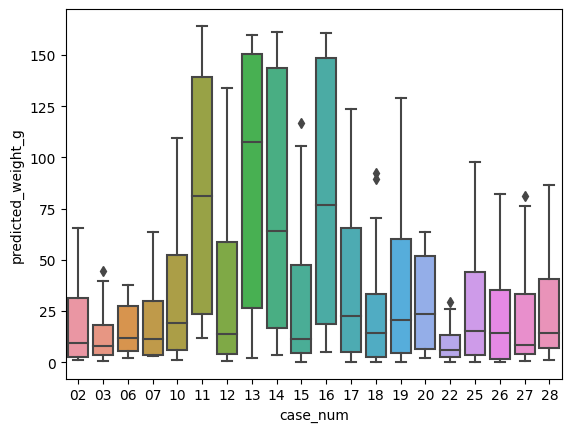

validation


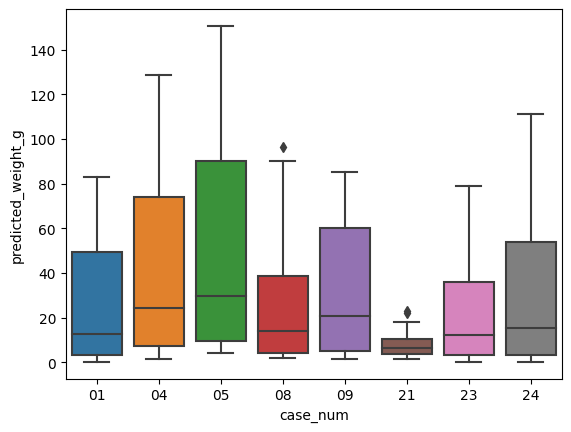

In [28]:
print('train')
tmp = label_df[label_df.case_num.isin(tr_case_num)]
sns.boxplot(x=tmp.case_num,y=tmp.predicted_weight_g)
plt.show()
print('validation')
tmp = label_df[label_df.case_num.isin(va_case_num)]
sns.boxplot(x=tmp.case_num,y=tmp.predicted_weight_g)
plt.show()

In [29]:
# X_train = pd.get_dummies(X_train,columns=['DAT','obs_time'])
# X_valid = pd.get_dummies(X_valid,columns=['DAT','obs_time'])

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(13440, 280) (5376, 280) (560, 3) (224, 3)


In [30]:
# X_train.head()

In [31]:
X_train.shape[0]/y_train.shape[0]

24.0

<br></br>

# 모델링

In [32]:
seq_length = 1
batch_size = 16
num_workers = 0

train_dataset = CustomDataset(input=X_train, label=y_train, infer_mode=False, seq_length=seq_length)
train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers) # CFG['BATCH_SIZE']

valid_dataset = CustomDataset(input=X_valid, label=y_valid, infer_mode=False, seq_length=seq_length)
valid_loader  = DataLoader(valid_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers) # CFG['BATCH_SIZE']

test_dataset = CustomDataset(input=test_input_df, label=test_label_df, infer_mode=True, seq_length=seq_length)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0) # CFG['BATCH_SIZE']

In [33]:
# [(x.size(),y.size()) for x,y in iter(train_loader)]
# [y for x,y in iter(train_loader)]
sum([y.size(0) for x,y in iter(train_loader)])

560

In [34]:
len([x for x,y in iter(train_loader)])

35

In [35]:
[(x[0].size(),x[1].size()) for x in train_loader]

[(torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), torch.Size([16, 1])),
 (torch.Size([16, 24, 279]), to

In [36]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        # print(x.shape,x_reshape.shape)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class NLinear(nn.Module):
    """
    Normalization-Linear
    """
    def __init__(self, seq_len, pred_len, td=True):
        super(NLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.Linear = nn.Linear(self.seq_len, self.pred_len)
        if td:
            self.Linear = TimeDistributed(self.Linear)
        # Use this line if you want to visualize the weights
        self.Linear.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'Linear' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)
        
    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seq_last = x[:,-1:,:].detach()
        x = x - seq_last
        x = self.Linear(x.permute(0,2,1)).permute(0,2,1)
        x = x + seq_last
        return x # [Batch, Output length, Channel]

In [46]:
class NLinear_Model(nn.Module):
    def __init__(self, seq_len, pred_len, input_size):
        super(NLinear_Model, self).__init__()
        super().__init__()
        
        dropout=0.5
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.gelu = nn.GELU()
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        
        self.activation = self.leakyrelu
        
        # nn.BatchNorm1d(64)
        nodes = [400,300,200,100]
        self.model = nn.Sequential(
            NLinear(seq_len ,nodes[0]), self.dropout, self.activation,
            NLinear(nodes[0],nodes[1]), self.dropout, self.activation,
            NLinear(nodes[1],nodes[2]), self.dropout, self.activation,
            NLinear(nodes[2],nodes[3]), self.dropout, self.activation,
            NLinear(nodes[3],pred_len),
        )

        self.fc   = nn.Linear(input_size,1)
        self.fc   = TimeDistributed(self.fc)
        # self._reinitialize()

        # for name, p in self.named_parameters():
        #     print(name, 'scinet' in name)
        
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)
        

#     def forward(self, x):
#         x = self.nlinear(x)
#         # x = self.bn(x)
#         x = self.dropout(x)
#         x = self.gelu(x)
        
#         x = self.fc(x[:,-1,:])
        
#         return x
        
#     def forward(self, x):
#         x = self.nlinear_1(x)
#         # x = self.bn(x)
#         x = self.dropout(x)
#         x = self.gelu(x)
        
#         x = self.nlinear_2(x)
#         # x = self.bn(x)
#         x = self.dropout(x)
#         x = self.gelu(x)
        
#         x = self.fc(x[:,-1,:])
        
#         return x

    def forward(self,x):
        x = self.model(x)
        return x[:,-1,:]

In [42]:
[x[0].shape for x in train_loader][0],[x.shape for x in test_loader][0]

(torch.Size([16, 24, 279]), torch.Size([16, 24, 279]))

In [43]:
# gc.collect()

In [47]:
seed_everything(CFG['SEED'])

input_size = [np.array(x[0]).shape for x in train_loader][0][2]
# model = Model(input_size = input_size)
model = NLinear_Model(seq_len=24, pred_len=1, input_size=input_size)
# model = BaseModel(
#     input_size = input_size,
#     hidden_sizes=[400,300],
#     dropout_rates=[0.2,0.2],
#     num_classes=seq_length,
#     num_layers=2,
#     bidirectional=True,
# )

model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-4, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=200, threshold_mode='abs',min_lr=1e-7, verbose=False)

CFG['ES_PATIENCE'] = 400
CFG['ES_VERBOSE']  = 0
best_model = train(
    model,
    optimizer=optimizer,
    train_loader=train_loader,
    valid_loader=valid_loader,
    scheduler=None,#scheduler,
    device=device,
    early_stopping=False,
    metric_period=1,
    epochs=30000,
    best_model_only=True,
    verbose=1,
)

# # https://docs.aws.amazon.com/sagemaker/latest/dg/studio-tensorboard.html
# tensorboard --logdir=runs

# sagemaker tensorboard
# 참조 : https://stackoverflow.com/questions/72760982/how-to-use-tensorboard-within-a-notebook-running-on-amazon-sagemaker-studio-lab

*[00001/30000] tr_loss : 49.07335, val_loss : 38.97192, elapsed : 6.37s, total : 6.37s, remaining : 190952.36s
*[00002/30000] tr_loss : 46.26134, val_loss : 38.36928, elapsed : 6.28s, total : 12.65s, remaining : 188516.62s
*[00003/30000] tr_loss : 45.37414, val_loss : 37.96886, elapsed : 6.31s, total : 18.96s, remaining : 189260.83s
*[00004/30000] tr_loss : 44.25990, val_loss : 37.69655, elapsed : 6.30s, total : 25.26s, remaining : 188999.69s
*[00005/30000] tr_loss : 43.12374, val_loss : 37.47837, elapsed : 6.28s, total : 31.54s, remaining : 188453.31s
*[00006/30000] tr_loss : 42.38018, val_loss : 37.30385, elapsed : 6.28s, total : 37.83s, remaining : 188471.65s
*[00007/30000] tr_loss : 41.92693, val_loss : 37.15141, elapsed : 6.29s, total : 44.12s, remaining : 188722.77s
*[00008/30000] tr_loss : 41.54345, val_loss : 37.01005, elapsed : 6.19s, total : 50.31s, remaining : 185708.63s
*[00009/30000] tr_loss : 41.27306, val_loss : 36.85821, elapsed : 6.11s, total : 56.42s, remaining : 1831


KeyboardInterrupt



<br>

Save/Load Model

In [ ]:
import datetime
# path = f'./model/best_model_tmp.pt'

# path = f'./model/best_model_004.pt'
path = f'./model/best_model.pt'

# torch.save(best_model.state_dict(), path)

In [ ]:
best_model = SCINet_Model(input_size = input_size)
best_model.load_state_dict(torch.load(path, map_location=device))

In [ ]:
best_model.to(device)
best_model.eval()
pred_list = []
true_list = []
with torch.no_grad():
    for X,y in iter(valid_loader): # train_loader, valid_loader
        X = X.float().to(device)

        model_pred = best_model(X).cpu().numpy().reshape(-1).tolist()
        # model_pred = np.exp(model_pred).tolist()
        
        y = y.cpu().numpy().reshape(-1).tolist()
        # y = np.exp(y).tolist()
        
        pred_list += model_pred
        true_list += y

In [ ]:
len([x.shape for x,y in iter(train_dataset)])

In [ ]:
len([x for x in np.array(pred_list)]),len([x for x in np.array(true_list)])

In [ ]:
size = int(len([x for x in np.array(pred_list)])/28)

In [ ]:
for i in range(size): # 3,25

    plot_df = pd.DataFrame({
        'pred' : pred_list,
        'true' : true_list,
    })[i*28:(i+1)*28].reset_index(drop=True)
    # plot_df = np.exp(plot_df)

    sns.lineplot(x=plot_df.index,y=plot_df.true,color='black')
    sns.lineplot(x=plot_df.index,y=plot_df.pred,color='red')
    # plt.title(random_num[i])
    plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(plot_df.pred,plot_df.true))

<br></br>

# Inference

In [ ]:
input_df.shape[0]/28, test_input_df.shape[0]/28

In [ ]:
test_dataset = CustomDataset(input=test_input_df, label=test_label_df, infer_mode=True, seq_length=seq_length)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0) # CFG['BATCH_SIZE']

In [ ]:
best_model.to(device)
best_model.eval()
pred_list = []
with torch.no_grad():
    for X in iter(test_loader):
        X = X.float().to(device)

        model_pred = best_model(X).cpu().numpy().reshape(-1).tolist()
        # model_pred = np.exp(model_pred).tolist()
        # print(np.array(model_pred))

        pred_list += model_pred

In [ ]:
# np.array(pred_list)

In [ ]:
sub = test_label_df.sort_values(['case_num','DAT'])
sub['predicted_weight_g'] = pred_list

i=0
for case_num in sub.case_num.unique():
    i+=1
    s = sub[sub.case_num==case_num].drop('case_num',axis=1)
    s.DAT = s.DAT-1
    print(i,s.isnull().sum())
    s.to_csv(f'./out/scinet/TEST_{case_num}.csv',index=False)

In [ ]:
import zipfile
os.chdir('/home/studio-lab-user/Dacon/6_상추생육환경생성')
os.chdir("./out/scinet/")
submission = zipfile.ZipFile("../scinet.zip", 'w')
for path in all_test_label_list:
    path = path.split('/')[-1]
    submission.write(path)
submission.close()
os.chdir('/home/studio-lab-user/Dacon/6_상추생육환경생성')

<br></br>